# MLP Assignment (Machine Learning MII-3411)
Kelompok :
- Juandito Batara (18/427582/PA/18542)
- Mario Adriel (18/430267/PA/18780)
- Francisca C. S. (18/427578/PA/18538)

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
import cv2
import random
from google.colab import drive

## Dataset 
- 3 kelas : sunflower, dandelion, rose
- 100 image perkelas
- split data : 80% training set, 20% testing set
- training data : 80 kelas 1 + 80 kelas 2 + 80 kelas 3

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path = Path('/content/gdrive/My Drive/dataset/flowers/')
DATA_PATH:str = '/content/gdrive/My Drive/dataset/flowers/'
classes:list = os.listdir(DATA_PATH)
width:int = 320
height:int = 240

print("3 kelas: ", classes)

3 kelas:  ['dandelion', 'sunflower', 'rose']


In [85]:
# Create DataFrame by listing image directory and its class

flowers = []

for types in classes:
    semua_bunga = os.listdir(data_path / types)
    for flower in semua_bunga:
        flowers.append((types, str(data_path /types) + '/' + flower))
      
flowers = pd.DataFrame(data=flowers, columns=['class', 'image name'], index=None)
flowers.head()

,class,image name
0,dandelion,/content/gdrive/My Drive/dataset/flowers/dande...
1,dandelion,/content/gdrive/My Drive/dataset/flowers/dande...
2,dandelion,/content/gdrive/My Drive/dataset/flowers/dande...
3,dandelion,/content/gdrive/My Drive/dataset/flowers/dande...
4,dandelion,/content/gdrive/My Drive/dataset/flowers/dande...


In [86]:
print("Jumlah semua bunga dalam dataset : ", len(flowers))
fl_count = flowers['class'].value_counts()
print("Bunga dalam setiap kategori: ")
print(fl_count)

Jumlah semua bunga dalam dataset :  300
Bunga dalam setiap kategori: 
sunflower    100
dandelion    100
rose         100
Name: class, dtype: int64


In [87]:
flowers['image name'][0]

'/content/gdrive/My Drive/dataset/flowers/dandelion/7249354462_21925f7d95_n.jpg'

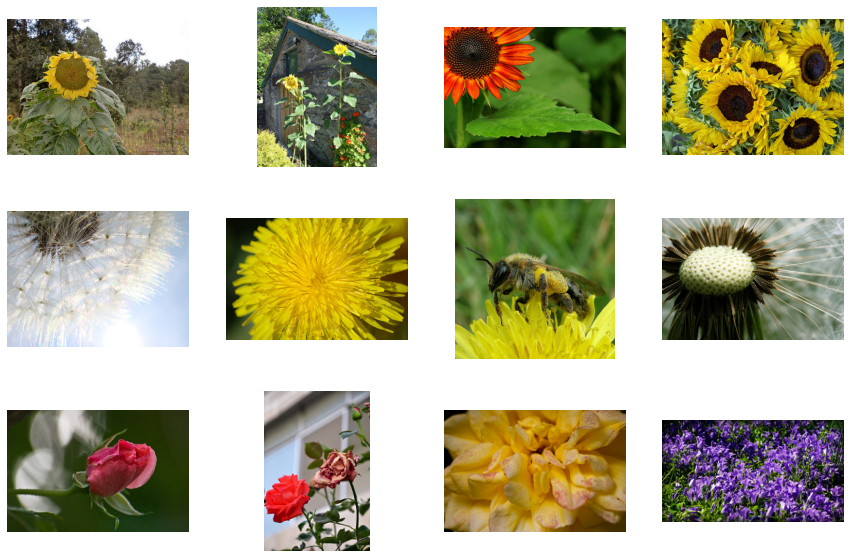

In [88]:
# Visualizing image previews

random_samples = []

for category in fl_count.index:
    samples = flowers['image name'][flowers['class'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

f, ax = plt.subplots(3,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

## Image Preprocess
Includes image resizing, grayscaling, and normalizing.

In [89]:
images:list = []
labels:list = []
np_img:list = []

for i in classes:
  label_path:str = DATA_PATH + i
  for image_file in os.listdir(label_path)[:100]:
    image = cv2.imread(label_path + '/' + image_file, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 240), interpolation=cv2.INTER_LINEAR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image / 255.0
    image_input = image.flatten()
    images.append(image)
    np_img.append(image_input)
    labels.append(i)
np_img = np.array(np_img)

In [90]:
print(labels[0])
print(images[0].shape)
print(np_img[0].shape)

dandelion
(240, 320)
(76800,)


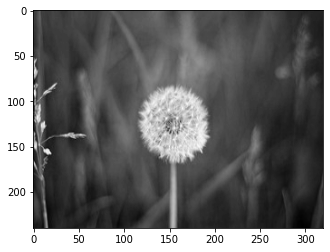

In [91]:
plt.imshow(images[0], cmap='gray')
plt.show()

## Data Splitting
Dataset dibagi menjadi 80% sebagai training data, dan 20% sebagai validation data.

In [92]:
images = np.array(images).reshape(-1, height, width, 1)
# images = images/255.0

labels = pd.DataFrame(labels)
labels = pd.get_dummies(labels)
labels = np.array(labels)

In [93]:
def split_data(X:list, y:list):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
  
  return X_train, X_test, y_train, y_test

In [94]:
X_train, X_test, y_train, y_test = split_data(images, labels)

In [95]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(240, 240, 320, 1)
(240, 3)
(60, 240, 320, 1)
(60, 3)


## Reshaping Data
Dilakukan reshape menyesuaikan bentuk input layer.

In [96]:
X_train_mlp = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_train_mlp = X_train_mlp.T
y_train_mlp = y_train.T

X_test_mlp = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_test_mlp = X_test_mlp.T
y_test_mlp = y_test.T

print(X_train_mlp.shape)
print(X_test_mlp.shape)
print(y_train_mlp.shape)
print(y_test_mlp.shape)

(76800, 240)
(76800, 60)
(3, 240)
(3, 60)


## Initialize Weights & Bias
Fungsi untuk memberi nilai awal pada bobot dan bias.

In [108]:
def inisialisasi(X_train, y_train):
    parameters: dict = {
        'theta_1': np.random.randn(128, X_train.shape[0]) * 0.1,
        'bias_1': np.zeros((128, 1)),
        'theta_2': np.random.randn(y_train.shape[0], 128) * 0.1,
        'bias_2': np.zeros((y_train.shape[0], 1))
    }
    return parameters

In [109]:
parameters:dict = inisialisasi(X_train_mlp, y_train.T)

print(parameters['theta_1'].shape)
print(parameters['bias_1'].shape)
print(parameters['theta_2'].shape)
print(parameters['bias_2'].shape)

(128, 76800)
(128, 1)
(3, 128)
(3, 1)


## Network Functions
Fungsi untuk proses training & testing dalam network.

In [110]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [111]:
def error(y_prediction, y_actual):
    m = y_actual.shape[1]

    # cross-entropy cost function
    logprobs = np.multiply(np.log(y_prediction), y_actual) +  np.multiply(np.log(1-y_prediction), (1-y_actual))
    cost = -1/m*np.sum(logprobs)
    cost = np.squeeze(cost)

    return cost

In [112]:
def feedforward(x, param):
    Z1 = np.dot(param["theta_1"], x) + param["bias_1"]
    A1 = sigmoid(Z1)
    Z2 = np.dot(param["theta_2"], A1) + param["bias_2"]
    prediction = sigmoid(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": prediction}

    return prediction, cache

In [113]:
def backward(param, cache, X, Y):

    dZ2 = cache["A2"]-Y
    dW2 = np.dot(dZ2,cache["A1"].T)/X.shape[1]
    db2 = np.sum(dZ2,axis =1,keepdims=True)/X.shape[1]

    dZ1 = np.dot(param["theta_2"].T,dZ2)*(1 - np.power(cache["A1"], 2))
    dW1 = np.dot(dZ1,X.T)/X.shape[1]
    db1 = np.sum(dZ1,axis =1,keepdims=True)/X.shape[1]

    gradients = {"delta_theta_1": dW1,
             "delta_bias_1": db1,
             "delta_theta_2": dW2,
             "delta_bias_2": db2}
    
    return gradients

In [114]:
def update_parameter(param, gradients, lr):
    
    parameters = {"theta_1": param["theta_1"] - lr * gradients["delta_theta_1"],
                  "bias_1": param["bias_1"] - lr * gradients["delta_bias_1"],
                  "theta_2": param["theta_2"] - lr * gradients["delta_theta_2"],
                  "bias_2": param["bias_2"] - lr * gradients["delta_bias_2"]}
    
    return parameters

In [115]:
def predict(param, X):

    prediction, cache = feedforward(X, param)
    Y_prediction = np.zeros((3, X.shape[1]))
    
    for i in range(prediction.shape[0]):
      for j in range(prediction.shape[1]):
          if prediction[0, j] <= 0.5:
              Y_prediction[0, j] = 0
          else:
              Y_prediction[0, j] = 1

    return Y_prediction

## Start Network
Fungsi ini akan melakukan training dan testing dalam waktu bersamaan.

In [116]:
def start_network(X_train, y_train, X_test, y_test, lr, ep):
    
    loss_list = []
    val_loss_list = []
    accuracy_list = []
    val_accuracy_list = []
    
    # inisialisasi parameter
    parameters = inisialisasi(X_train, y_train)

    for i in range(0, ep):
        #feedforward
        prediction_train, cache = feedforward(X_train, parameters)
        prediction_test, cache_test = feedforward(X_test, parameters)

        #hitung prediksi
        y_prediction_test = predict(parameters, X_test)
        y_prediction_train = predict(parameters, X_train)

        #hitung akurasi
        accuracy_train = 1 - np.mean(np.abs(y_prediction_train - y_train))
        accuracy_test = 1 - np.mean(np.abs(y_prediction_test - y_test))

        accuracy_list.append(accuracy_train)
        val_accuracy_list.append(accuracy_test)

        #hitung error
        loss_value = error(prediction_train, y_train)
        val_loss_value = error(prediction_test, y_test)

        loss_list.append(loss_value)
        val_loss_list.append(val_loss_value)

        #backward
        gradients = backward(parameters, cache, X_train, y_train)

        #update
        parameters = update_parameter(parameters, gradients, lr)
        
        print(f"Epoch {i+1}/{ep} - loss: {loss_value} - val_loss: {val_loss_value} - accuracy: {accuracy_train} - val_accuracy: {accuracy_test}")

    plt.figure(figsize=(10, 5))
    plt.plot(accuracy_list)
    plt.plot(val_accuracy_list)
    plt.ylim([0, 1])
    plt.yticks(np.arange(0, 1, 0.1))
    plt.title('Akurasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(loss_list)
    plt.plot(val_loss_list)
    plt.title('Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return parameters

Epoch 1/50 - loss: 2.122379748355195 - val_loss: 2.098638676371208 - accuracy: 0.6611111111111111 - val_accuracy: 0.6611111111111111
Epoch 2/50 - loss: 2.827776914331792 - val_loss: 3.017759068967903 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 3/50 - loss: 2.102195137578533 - val_loss: 2.1697572568294627 - accuracy: 0.575 - val_accuracy: 0.5777777777777777
Epoch 4/50 - loss: 2.927837978341382 - val_loss: 2.8167996037686076 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 5/50 - loss: 2.348179874262768 - val_loss: 2.4960013305409725 - accuracy: 0.6333333333333333 - val_accuracy: 0.6611111111111111
Epoch 6/50 - loss: 2.352846439381304 - val_loss: 2.250695697037563 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 7/50 - loss: 2.3571827878036347 - val_loss: 2.5189785028299485 - accuracy: 0.6708333333333334 - val_accuracy: 0.6833333333333333
Epoch 8/50 - loss: 2.3799757588164128 - val_loss: 2.2682413008628606 - accura

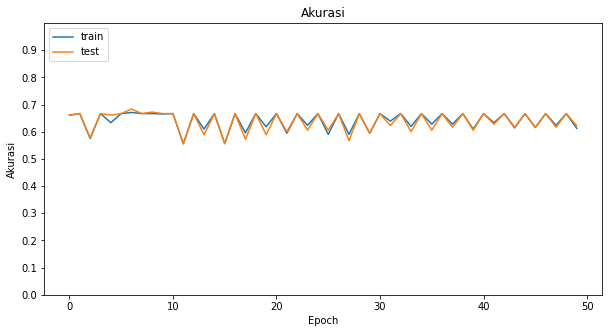

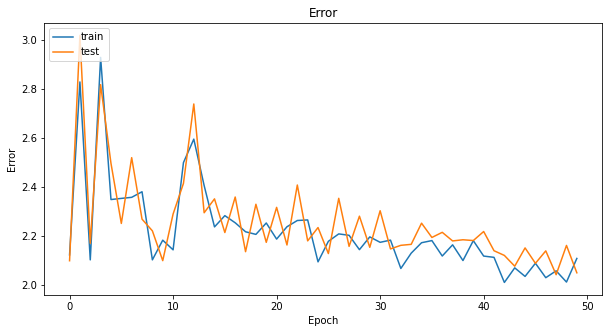

In [117]:
check1 = start_network(X_train_mlp, y_train_mlp, X_test_mlp, y_test_mlp, lr = 0.1, ep = 50)

Epoch 1/50 - loss: 2.2787415993315108 - val_loss: 2.334679770970012 - accuracy: 0.5597222222222222 - val_accuracy: 0.5611111111111111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Epoch 2/50 - loss: 8.77661150124836 - val_loss: 8.312013012438339 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 3/50 - loss: 18.199727521660193 - val_loss: 19.828078605354357 - accuracy: 0.5555555555555556 - val_accuracy: 0.5555555555555556
Epoch 4/50 - loss: 24.391202586083978 - val_loss: 23.477058582768827 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 5/50 - loss: 15.503018620531895 - val_loss: 14.669380805928203 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 6/50 - loss: 32.00172586096099 - val_loss: 34.178946843374355 - accuracy: 0.5555555555555556 - val_accuracy: 0.5555555555555556
Epoch 7/50 - loss: 24.709646134372615 - val_loss: 23.89662138376626 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 8/50 - loss: 14.893998713731847 - val_loss: 14.105484812423908 - accuracy: 0.6666666666666667 - val_accuracy: 0.6666666666666667
Epoch 9/50 - loss: 33.225736943979584 - val_loss: 35.4886678

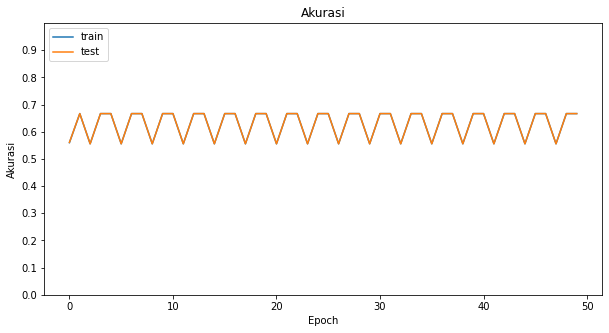

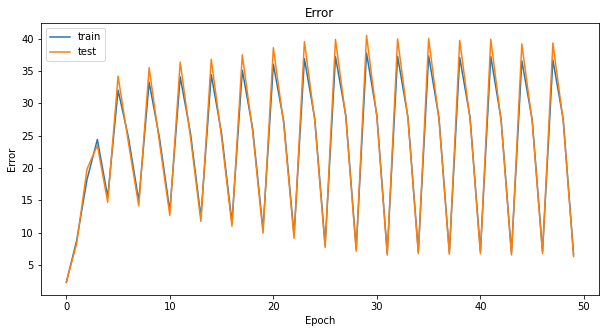

In [118]:
check2 = start_network(X_train_mlp, y_train_mlp, X_test_mlp, y_test_mlp, lr = 0.8, ep = 50)